# 08.3 Copulas
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

Most traded products, however, depend on joint default events, such as:
- first-to-default baskets,
- CDO tranche spreads (Equity, Mezzanine, Senior),
- index tranches (iTraxx, CDX).

To price and risk-manage these portfolios, we need a model for the dependence structure between several default times $(\tau_1, \tau_2, \ldots, \tau_m)$. Reduced-form models deliver survival probabilities for each name, but do not specify the joint distribution. Copulas provide a mathematically consistent way to combine: known marginal survival curves (from CDS calibration), a chosen dependence structure.

**This notebook**: 

Develops the theoretical concepts and provides simple numerical illustrations. This ultimate section extends the intensity-based credit modelling framework to multi-name credit portfolios.

# 1. Why Copulas in Credit?

Single-name CDS calibration gives us, for each obligor $i$,

$$Q(\tau_i > t) = S_i(t),$$

the marginal survival curve.

But for multi-name products we need the joint distribution:

$$Q(\tau_1 > t_1, \ldots, \tau_m > t_m).$$

Structural or intensity models alone do not determine this.

**Copulas** allow us to specify any dependence while preserving the marginals exactly.


**Common Misunderstanding** : Copula ≠ Correlation Correlation is a single number.
A copula is a function encoding all aspects of dependence:
- non-linear dependence,
- tail dependence,
- asymmetry,
- dependence of extremes even when correlation ≈ 0.

Two copulas with the same correlation may have completely different joint default behaviours.
This is central to CDO pricing: tranches are extremely sensitive to tail dependence.

# 2. Sklar's Theorem and the Role of a Copula

Let $X_1, \ldots, X_m$ be continuous random variables with marginal CDFs $F_i$.

Sklar's theorem states that the joint CDF is uniquely expressed as:

$$P(X_1 \leq x_1, \ldots, X_m \leq x_m) = C(F_1(x_1), \ldots, F_m(x_m)),$$

where:

- $C: [0,1]^m \to [0,1]$ is a copula,
- the marginals $F_i$ are preserved exactly,
- all dependence is encoded in $C$.

Thus:

- **marginals** describe scales (default intensities, survival curves),
- **copula** describes dependence (clustering of defaults, tail effects).

This decomposition is fundamental for modern credit modelling.


# 3. Core Properties of Copulas

## 3.1 Monotone invariance

If $Y_i = g_i(X_i)$ with $g_i$ strictly increasing, the copula of $(Y_1, \ldots, Y_m)$ is the same as that of $(X_1, \ldots, X_m)$.

Dependence is unaffected by monotonic transformations.

## 3.2 Independence copula

$$C(u_1, \ldots, u_m) = \prod_{i=1}^{m} u_i$$

## 3.3 Fréchet–Hoeffding bounds

Define the set of all possible copulas (i.e., all possible dependence structures):

**Lower bound (counter-monotonic)**

$$C^-(u,v) = \max(u + v - 1, 0)$$

**Upper bound (comonotonic)**

$$C^+(u,v) = \min(u,v)$$

All copulas lie between these bounds.

These concepts allow us to assess whether a chosen dependence model is plausible.


# 4. Copulas Used in Credit Modelling

## 4.1 Gaussian Copula (industry standard pre-2008)

**One-factor Gaussian copula**

Let

$$U_i = \Phi(\rho Z + \sqrt{1-\rho^2} \epsilon_i),$$

where $Z, \epsilon_i \sim N(0,1)$ i.i.d.

Then:

- marginals are uniform on $[0,1]$,
- dependence is entirely governed by correlation $\rho$,
- implementation is extremely fast.

**Strengths**

- simple,
- fast simulation,
- calibratable via rank correlation.

**Weaknesses**

- extremely weak dependence in the joint left tail,
- underestimates the clustering of defaults,
- major driver behind CDO mispricing pre-2007.

This model assumed that "extreme" joint-default scenarios were almost impossible.

## 4.2 Student-t Copula

Same construction but with a t-distribution and degrees of freedom $\nu$.

**Benefits:**

- heavy tails,
- significantly stronger lower-tail dependence,
- more realistic joint-default behaviour.

## 4.3 Archimedean Copulas (Clayton, Gumbel, Frank)

Useful when we need:

- asymmetric dependence,
- explicit tail emphasis.

**Examples:**

- **Clayton:** strong lower-tail dependence → suited for simultaneous defaults.
- **Gumbel:** strong upper tail.
- **Frank:** symmetric, flexible but not tail-heavy.

In credit modelling, Clayton is frequently used to model systemic downturns.


# 5. Numerical Illustrations

We now provide simple examples to illustrate: simulation of Gaussian vs t copulas, comparison of tail dependence, effect on joint default probabilities.
These examples are intentionally minimal: their goal is to build intuition, not to implement full credit portfolio pricing.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## 5.1 Gaussian vs t Copula Simulation (2 names)

In [ ]:
def simulate_gaussian_copula(rho, n=50000):
    mean = [0,0]
    cov = [[1, rho],
           [rho, 1]]
    X = np.random.multivariate_normal(mean, cov, size=n)
    U = st.norm.cdf(X)
    return U[:,0], U[:,1]

def simulate_t_copula(rho, df=4, n=50000):
    mean = [0,0]
    cov = [[1, rho],
           [rho, 1]]
    Z = np.random.multivariate_normal(mean, cov, size=n)
    chi = np.sqrt(df / np.random.chisquare(df, size=n))[:,None]
    T = Z * chi   # student-t samples
    U = st.t.cdf(T, df=df)
    return U[:,0], U[:,1]

## 5.2 Empirical Tail Dependence

In [ ]:
def tail_dependence(u, v, threshold=0.05):
    return np.mean((u < threshold) & (v < threshold))

U1_g, U2_g = simulate_gaussian_copula(rho=0.3)
U1_t, U2_t = simulate_t_copula(rho=0.3, df=4)

td_gauss = tail_dependence(U1_g, U2_g)
td_t     = tail_dependence(U1_t, U2_t)

print("Empirical lower-tail dependence")
print(f"Gaussian copula: {td_gauss:.5f}")
print(f"t-copula       : {td_t:.5f}")

Empirical lower-tail dependence
Gaussian copula: 0.00696
t-copula       : 0.01136


The Gaussian copula shows almost no lower-tail dependence (≈0.007): the probability that both names fall simultaneously into their worst 5% outcomes is extremely small.
The t-copula exhibits noticeably stronger tail dependence (≈0.011), meaning joint extreme events—such as simultaneous defaults—occur roughly twice as often under a heavy-tailed dependence structure.

We plot :

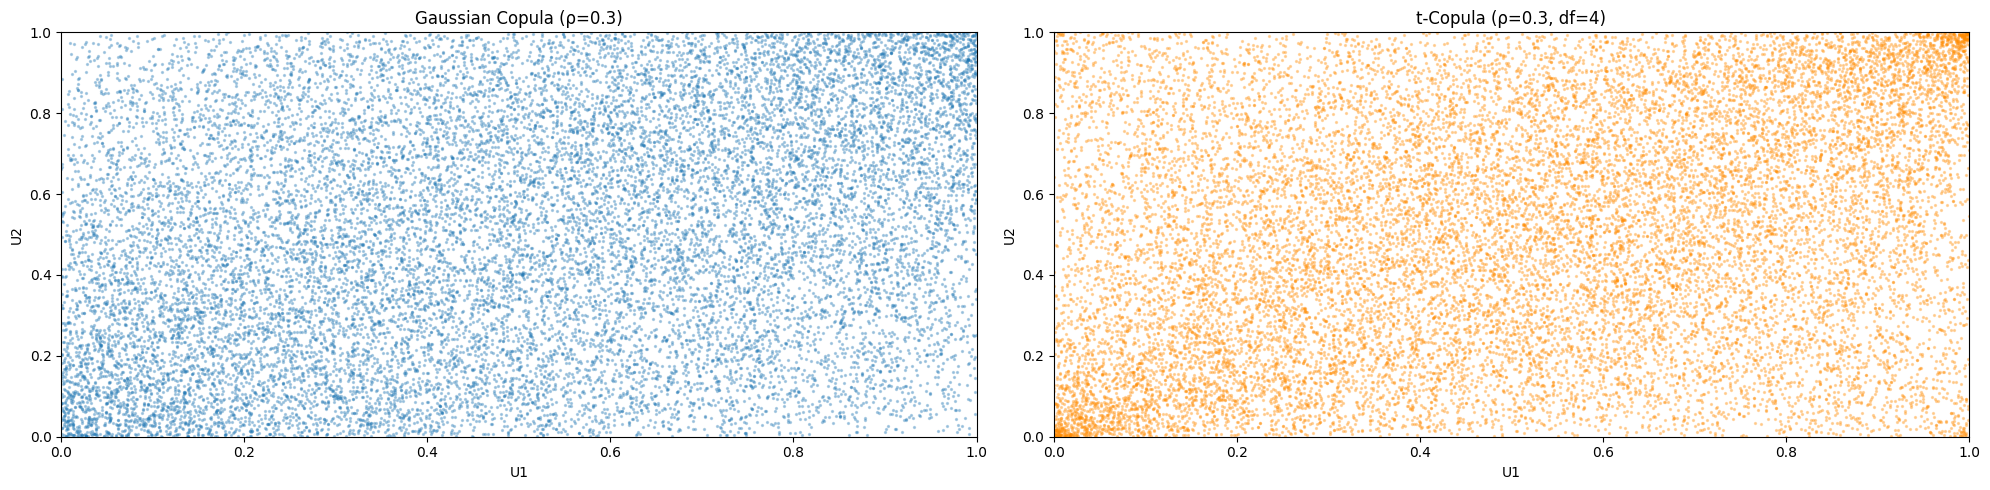

In [8]:
# Scatter comparison for Gaussian vs t-copula
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.scatter(U1_g[:19000], U2_g[:19000], s=2, alpha=0.3)
plt.title("Gaussian Copula (ρ=0.3)")
plt.xlabel("U1")
plt.ylabel("U2")
plt.xlim(0,1)
plt.ylim(0,1)

plt.subplot(1,2,2)
plt.scatter(U1_t[:19000], U2_t[:19000], s=2, alpha=0.3, color='darkorange')
plt.title("t-Copula (ρ=0.3, df=4)")
plt.xlabel("U1")
plt.ylabel("U2")
plt.xlim(0,1)
plt.ylim(0,1)

plt.tight_layout()
plt.show()

The Gaussian copula shows almost no mass near the lower-left corner, while the t-copula exhibits clear clustering there. This confirms that the t-copula produces stronger joint extreme events (lower-tail dependence) even with the same linear correlation.